In [2]:
! pip install torchvision


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:


import torch.nn as nn

import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [24]:
# Proceed with the dataset loading and transformations as before
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict


In [25]:
import json
import os
import shutil

# Path to your JSON file
json_file = 'corrected_large_file.json'

# Load the JSON data
with open(json_file, 'r') as f:
    data = json.load(f)

# Define the source and destination directories
source_dir = 'photos'
destination_dir = 'photos_class'


# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Create a mapping from photo_id to class label
for item in data:
    photo_id = item['photo_id']
    label = item['label']

    # Ensure the class folder exists in the destination
    
    class_folder = os.path.join(destination_dir, label)
    os.makedirs(class_folder, exist_ok=True)

    # Get the full path of the photo in the source directory
    photo_path = os.path.join(source_dir, photo_id + '.jpg')

    # Check if the photo exists and move it
    if os.path.exists(photo_path):
        shutil.copy(photo_path, class_folder)
    else:
        print(f"Photo {photo_id}.jpg not found in {source_dir}")



Photo 9RDbbAZB0HnL4hndCWB58w.jpg not found in photos


In [26]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from PIL import Image, UnidentifiedImageError
import os


def is_valid_image(file_path):
    try:
        # Try opening the image to check if it's valid
        Image.open(file_path)
        return True
    except (IOError, OSError, UnidentifiedImageError):

      
        return False
    
    
# Define the transformations to apply to images (if needed)
transform = transforms.Compose([
    
    transforms.Resize((64, 64)),
    transforms.ToTensor()

])

# Load the dataset using ImageFolder 
# This function is used to load a dataset in a directory 
#structure where images are organized by class in subfolders.
dataset = datasets.ImageFolder(
    root='photos_class',  # Path to your 'photos' folder
    transform=transform ,
    is_valid_file=is_valid_image  # Apply transformations if needed
)

# Limit to 500 images per class
class_indices = defaultdict(list)

# Group indices by class
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Fetch first 500 images for each class
subset_indices = []
for indices in class_indices.values():
    subset_indices.extend(indices[:300])  # Limit to 500 images per class

# Create a subset dataset using the subset indices
subset_dataset = Subset(dataset, subset_indices)

# DataLoader for the subset, to handle batching and shuffling
dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)
print("Number of images in subset:", len(subset_dataset))


Classes: ['drink', 'food', 'inside', 'menu', 'outside']
Number of images in subset: 1500


In [27]:
for real_imgs, _ in dataloader:
    print(type(real_imgs))  # Check the type of real_imgs
    break  # Only check the first batch to save time


<class 'torch.Tensor'>


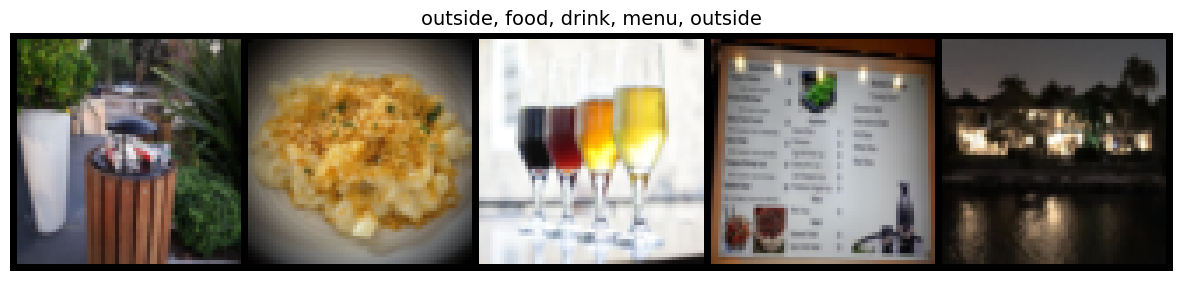

In [28]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import random

# Function to display 5 random images
def display_random_images(dataset, class_names, num_images=5):
    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    
    # Fetch the images and labels using the indices
    selected_data = [dataset[i] for i in random_indices]
    images, labels = zip(*selected_data)  # Separate images and labels
    
    # Create a grid of images
    grid = make_grid(list(images), nrow=num_images, normalize=True)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0))  # Convert from CHW to HWC format for display
    plt.axis('off')
    plt.title(", ".join([class_names[label] for label in labels]), fontsize=14)
    plt.show()

# Call the function to display images
display_random_images(subset_dataset, class_names, num_images=5)



In [29]:

# Hyperparameters
latent_dim = 100  # Dimension of the noise vector
image_size = 64   # Size of generated images (64x64)
img_channels = 3     # Number of image channels (e.g., 1 for grayscale, 3 for RGB)
batch_size = 128  # Batch size for training
lr = 0.0002       # Learning rate for Adam optimizer
beta1 = 0.5       # Beta1 for Adam optimizer
epochs = 100      # Number of training epochs


In [1]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128, out_channels=img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        return self.model(z)


NameError: name 'nn' is not defined

In [31]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: channels x 64 x 64
            nn.Conv2d(in_channels=img_channels, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Outputs a probability
        )

    def forward(self, img):
        out = self.model(img)  # Output shape: (batch_size, 1, h, w)
        return out.view(out.size(0), -1).mean(dim=1)  #


In [32]:
# Initialize the models
generator = Generator()
discriminator = Discriminator()

In [33]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [34]:
# Define optimizers and loss function
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch [1/20], Batch [0/24], D Loss: 0.0005, G Loss: 8.8978
Epoch [2/20], Batch [0/24], D Loss: 0.0003, G Loss: 9.6615
Epoch [3/20], Batch [0/24], D Loss: 0.0003, G Loss: 9.6794
Epoch [4/20], Batch [0/24], D Loss: 0.0003, G Loss: 9.8625
Epoch [5/20], Batch [0/24], D Loss: 0.0002, G Loss: 9.7396


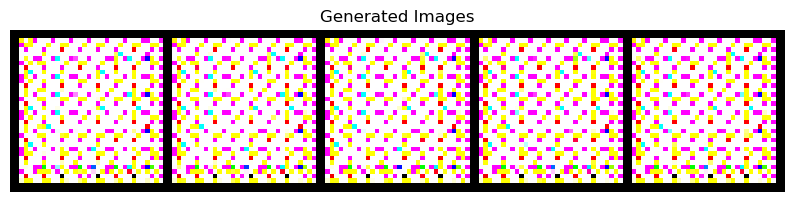

Epoch [6/20], Batch [0/24], D Loss: 0.0002, G Loss: 9.8872
Epoch [7/20], Batch [0/24], D Loss: 0.0001, G Loss: 10.0312
Epoch [8/20], Batch [0/24], D Loss: 0.0002, G Loss: 9.6272
Epoch [9/20], Batch [0/24], D Loss: 0.0002, G Loss: 10.1759
Epoch [10/20], Batch [0/24], D Loss: 0.0002, G Loss: 9.9899


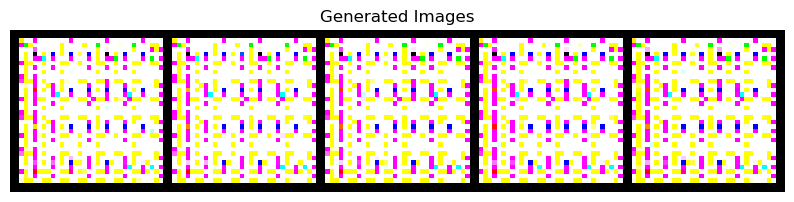

Epoch [11/20], Batch [0/24], D Loss: 0.0002, G Loss: 10.2443
Epoch [12/20], Batch [0/24], D Loss: 0.0003, G Loss: 9.0569
Epoch [13/20], Batch [0/24], D Loss: 0.0004, G Loss: 9.6140
Epoch [14/20], Batch [0/24], D Loss: 0.0002, G Loss: 9.9101
Epoch [15/20], Batch [0/24], D Loss: 0.0002, G Loss: 10.2315


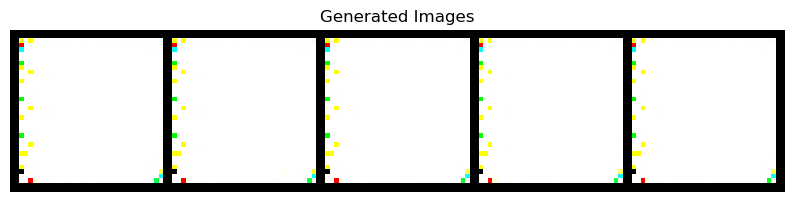

Epoch [16/20], Batch [0/24], D Loss: 0.0002, G Loss: 10.4343
Epoch [17/20], Batch [0/24], D Loss: 0.0001, G Loss: 10.3324
Epoch [18/20], Batch [0/24], D Loss: 0.0001, G Loss: 10.2296
Epoch [19/20], Batch [0/24], D Loss: 0.0002, G Loss: 10.0238
Epoch [20/20], Batch [0/24], D Loss: 0.0001, G Loss: 10.6250


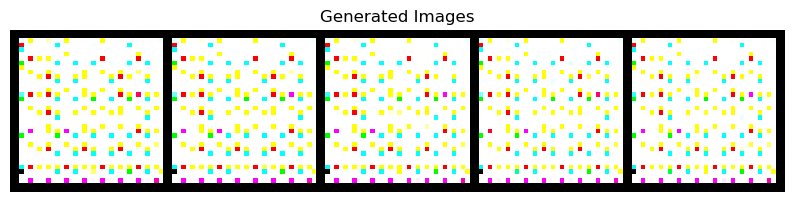

In [47]:


import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils

# Function to generate and save images
def generate_images(generator, num_images=5, latent_dim=100, save_path=None):
    """
    Generate and save images using the Generator.

    """
    generator.eval()  # Set Generator to evaluation mode

    with torch.no_grad():
        # Generate random noise vectors
        z = torch.randn(num_images, latent_dim, 1, 1).to(device)

        # Generate images
        fake_imgs = generator(z).cpu()

        # Create a grid of images
        img_grid = vutils.make_grid(fake_imgs, normalize=True, nrow=num_images)

        # Display the grid
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss on real images
        outputs_real = discriminator(real_imgs).view(batch_size, -1)
        d_loss_real = criterion(outputs_real, real_labels)

        # Discriminator loss on fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z).detach()
        outputs_fake = discriminator(fake_imgs).view(batch_size, -1)
        d_loss_fake = criterion(outputs_fake, fake_labels)

        # Total Discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs).view(batch_size, -1)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # Print training progress
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Generate and save images at the end of each epoch
    if (epoch + 1) % 5 == 0:  # Save every 5 epochs
        save_path = f"generated_images_epoch_{epoch+1}.png"
        generate_images(generator, num_images=5, latent_dim=latent_dim, save_path=save_path)
           





In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Preprocess images
preprocessed_images = preprocess_input(resized_images)  # Shape: (num_samples, 299, 299, 3)


In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the pretrained InceptionV3 model
inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

# Get predictions
predictions = inception_model.predict(preprocessed_images)  # Shape: (num_samples, feature_dim)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step


In [ ]:
def calculate_inception_score(predictions, splits=10, epsilon=1e-16):
    """
    Calculate the Inception Score (IS) for a set of images.
    Args:
        predictions: The predictions output by the InceptionV3 model.
        splits: Number of splits to compute IS.
        epsilon: Small constant to avoid log(0) or divide-by-zero.
    Returns:
        mean IS and standard deviation of IS across splits.
    """
    scores = []
    split_size = predictions.shape[0] // splits
    for i in range(splits):
        split = predictions[i * split_size:(i + 1) * split_size, :]
        split = np.clip(split, epsilon, 1.0)  # Avoid zero values
        p_y = np.mean(split, axis=0)
        p_y = np.clip(p_y, epsilon, 1.0)  # Avoid zero probabilities
        kl_divergence = split * (np.log(split) - np.log(p_y[np.newaxis, :]))
        kl_divergence = np.sum(kl_divergence, axis=1)
        scores.append(np.exp(np.mean(kl_divergence)))
    return np.mean(scores), np.std(scores)



In [ ]:
mean_is, std_is = calculate_inception_score(predictions)
print(f"Inception Score: {mean_is} ± {std_is}")

Inception Score: 4034.119140625 ± 2100.950927734375


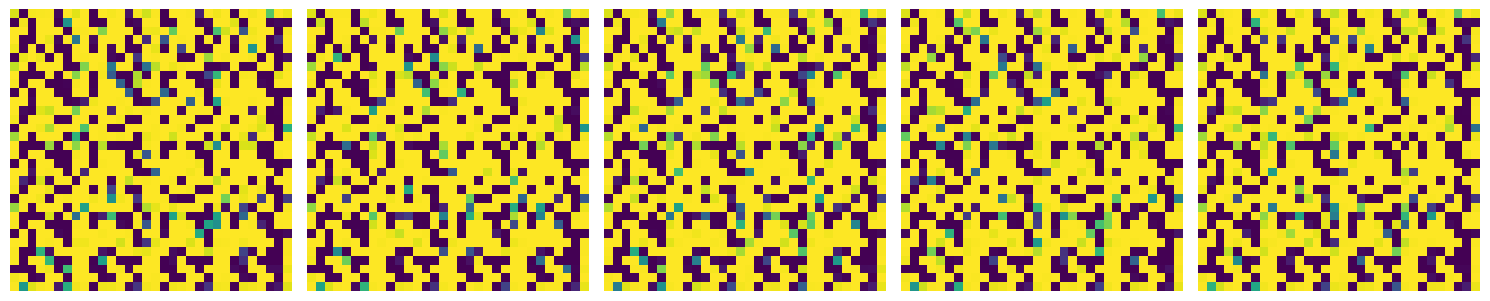

In [ ]:
#Show 5 Generated Images
import matplotlib.pyplot as plt

# Generate 5 random noise vectors
num_images = 5
latent_dim = 100  # Use the same latent dimension as defined in your model
z = torch.randn(num_images, latent_dim, 1, 1, device=device)

# Set generator to evaluation mode
generator.eval()

# Generate fake images
with torch.no_grad():  # No gradients needed for inference
    fake_images = generator(z).cpu()  # Move to CPU for visualization

# Reshape and scale the images for display
fake_images = (fake_images + 1) / 2  # Assuming generator outputs are in range [-1, 1]

# Plot the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = fake_images[i].permute(1, 2, 0).numpy()  # Convert CHW to HWC for matplotlib
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()
